In [1]:
import rasterio as rio
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import mean_squared_error
import seaborn as sns
from functools import reduce

In [2]:
def scaled(x):
    min_val, max_val = np.percentile(x, (2, 98))

    # Scale the pixel values to the range of 0-255
    return np.interp(x, (min_val, max_val), (0, 255)).astype(np.uint8)

def sigmoid(x):
    return 255 / (1 + np.exp(-4 * (scaled(x) / 255 - 0.5)))

In [3]:
def get_detect_cloud_bands(img):
    bands = [sigmoid(img.read(b)) for b in img.indexes]
    bands = np.stack(bands)
    return bands.transpose(1,2,0).astype(np.uint)

In [4]:
path = Path('../../imgs')
images = {p.name: p  for p in path.iterdir()}
path_imgs = [im for im in images['s2'].iterdir()]
rio_cloudless = [get_detect_cloud_bands(rio.open(path)) for path in path_imgs]
path_imgs = [im for im in images['s2_cloudy'].iterdir()]
rio_cloudies = [get_detect_cloud_bands(rio.open(path)) for path in path_imgs]

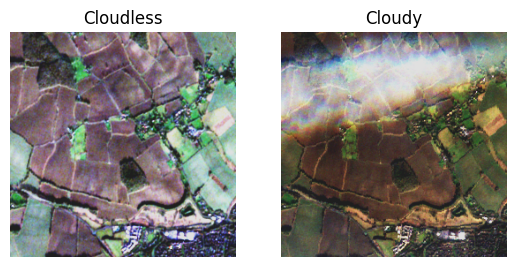

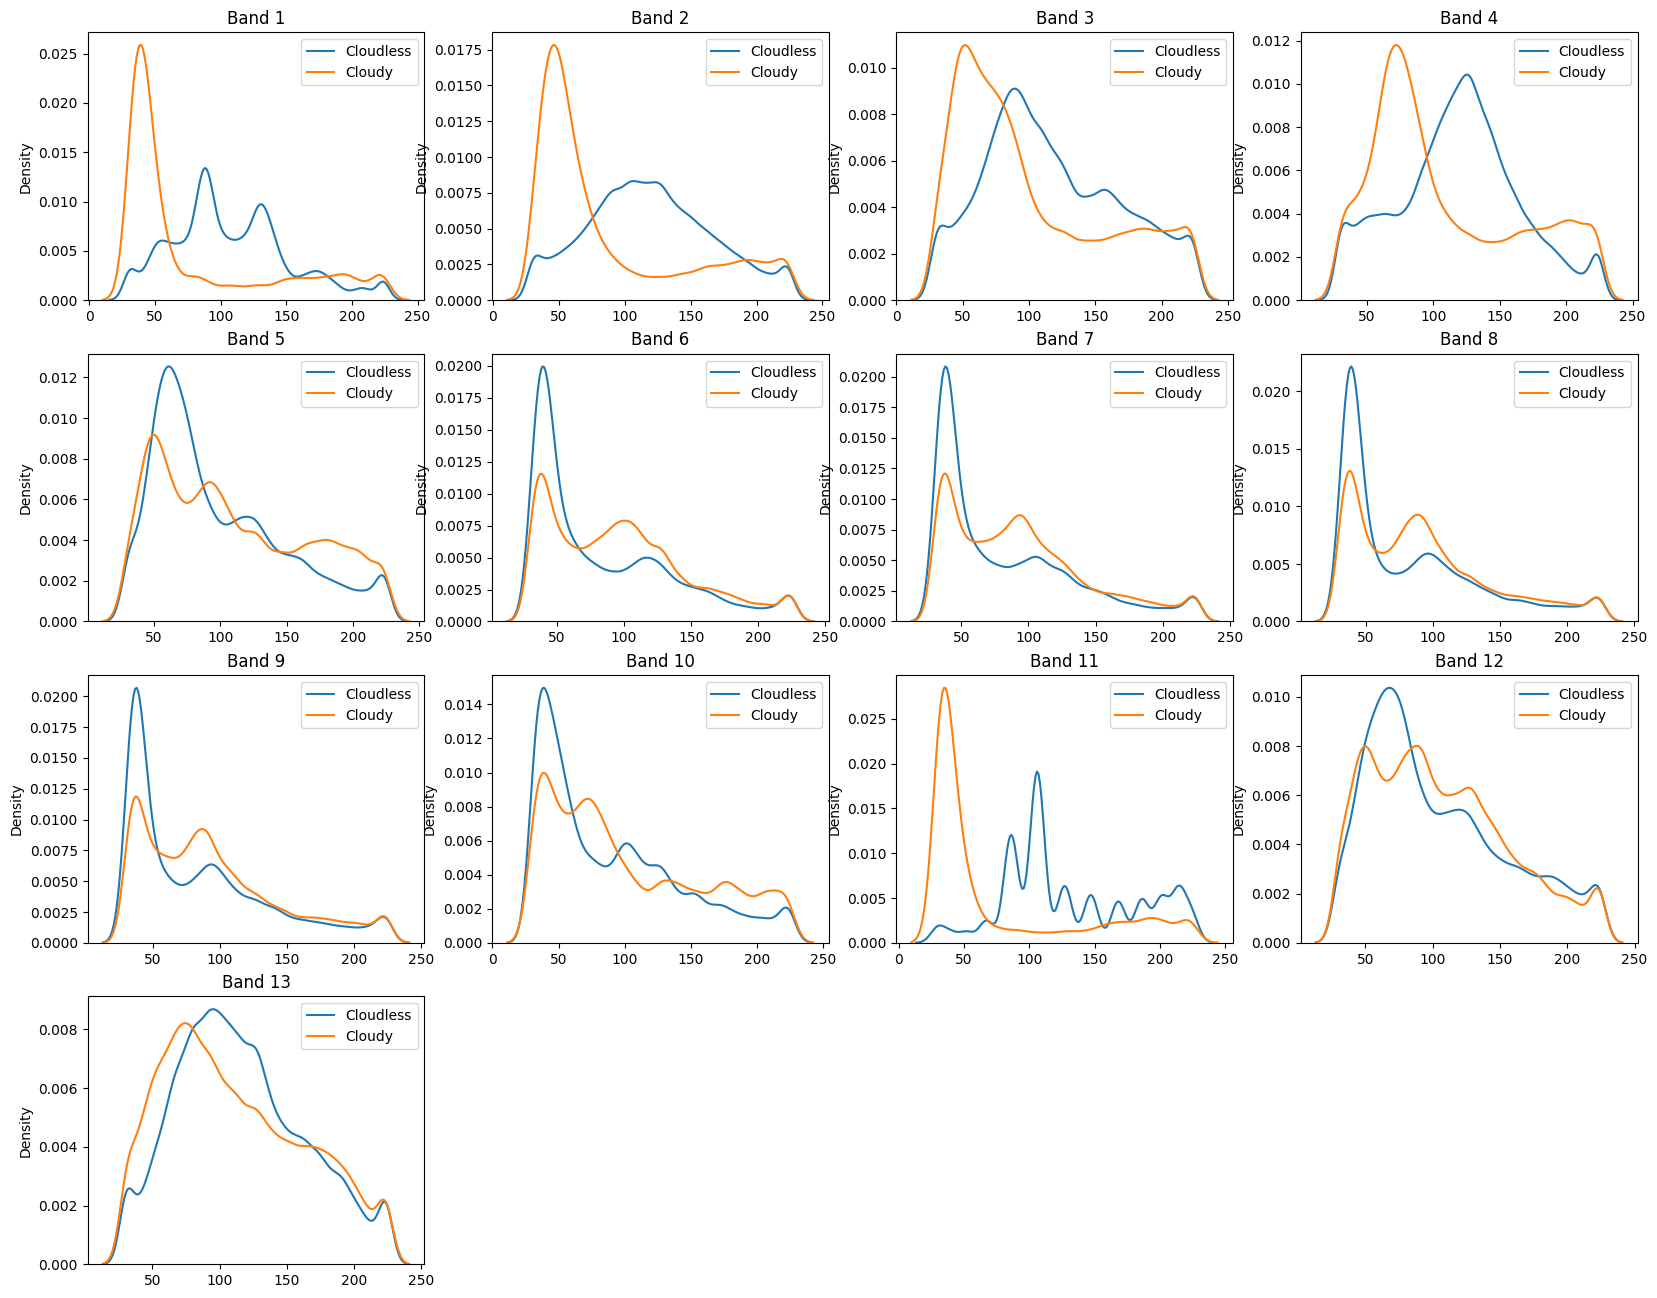

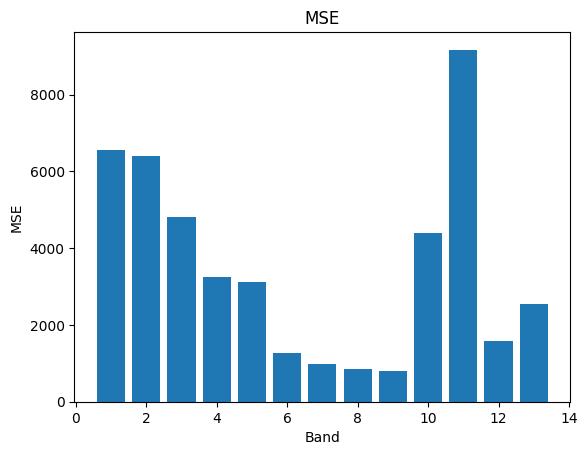

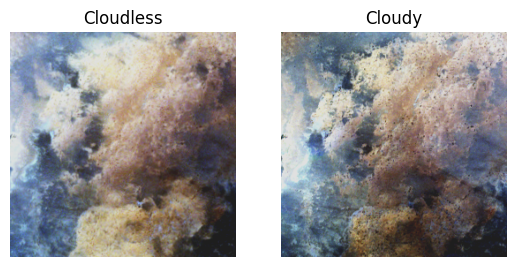

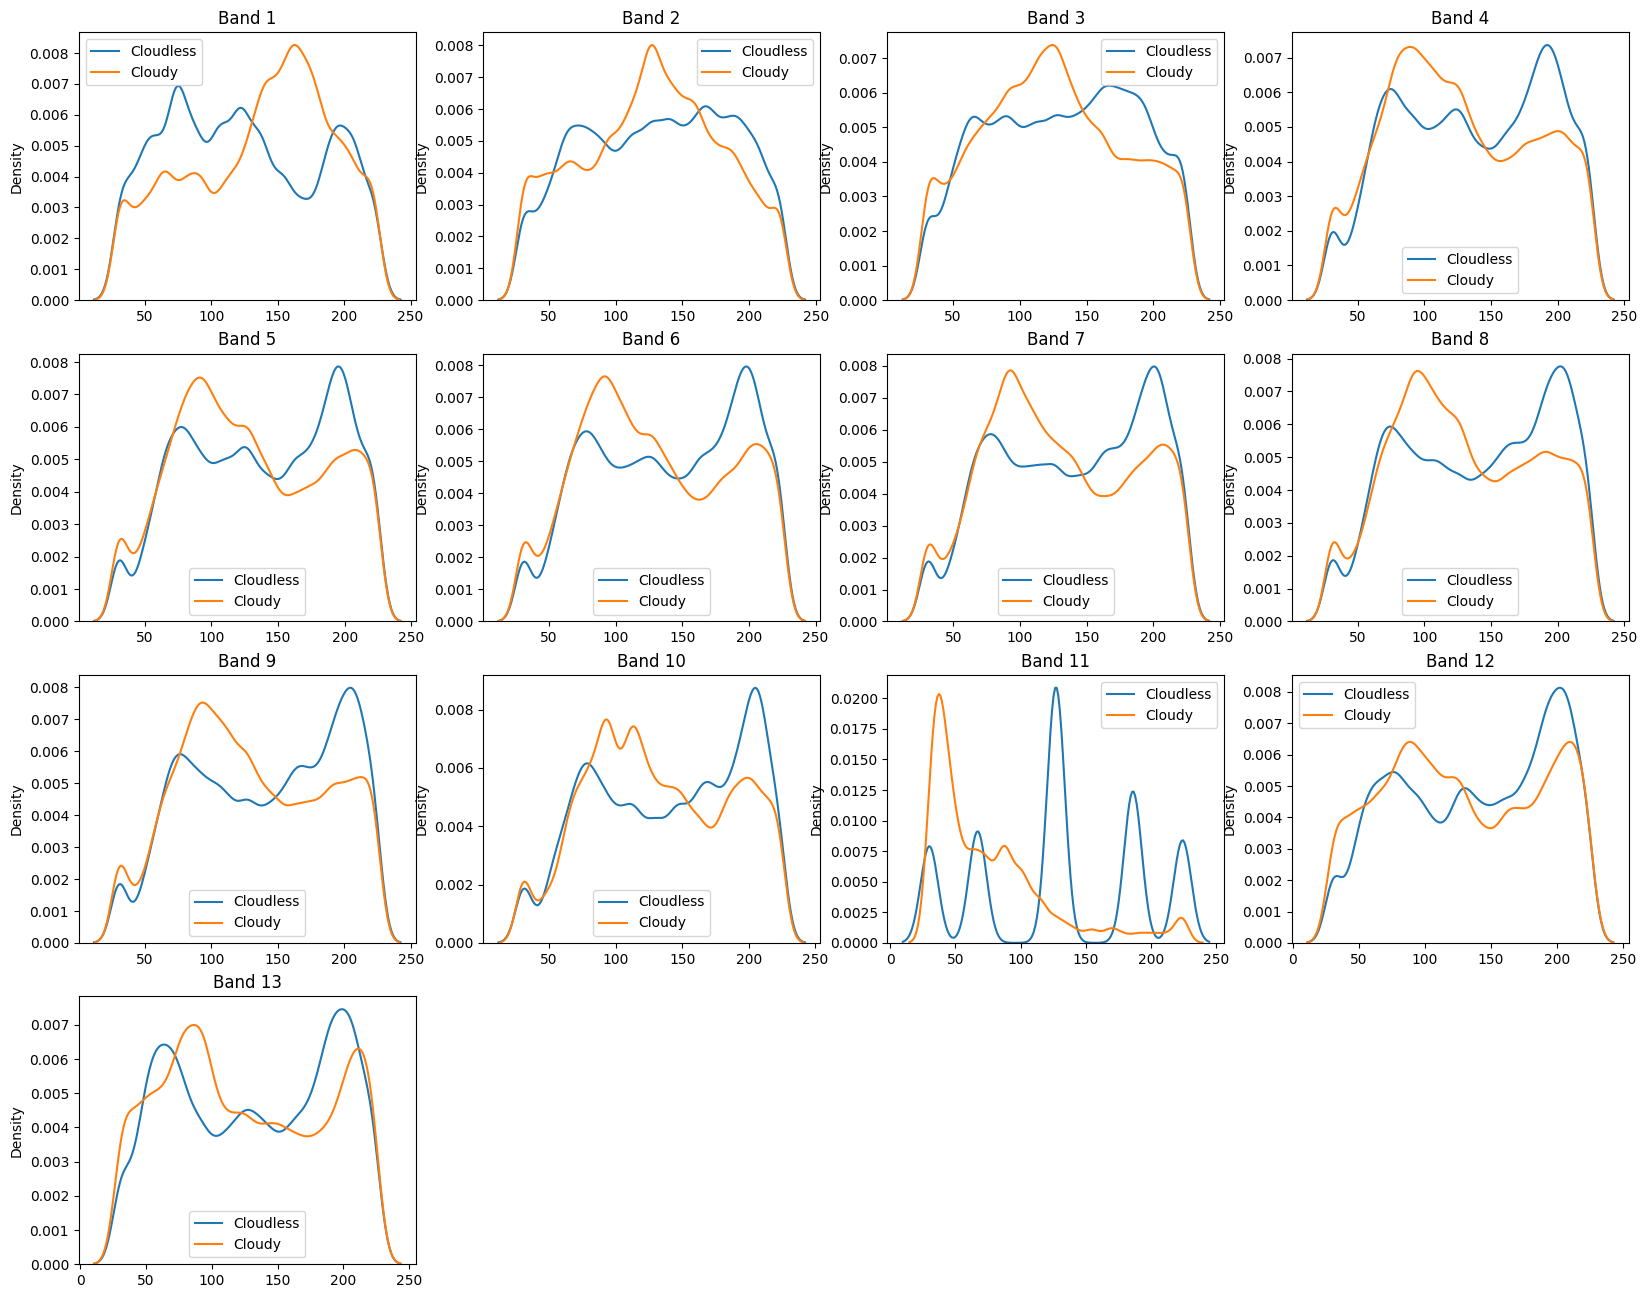

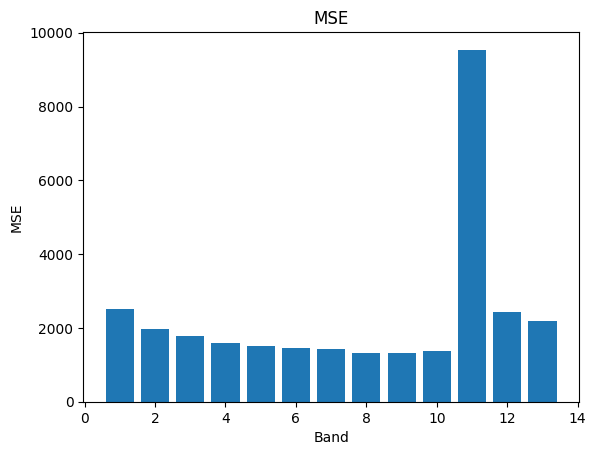

In [10]:
def plot_tile(title, img, ax):
    ax.set_title(title)
    ax.imshow(img[:, :, [3,2,1]])
    ax.axis('off')

def flatten(xs):
    return reduce(lambda x, y: list(x) + list(y), xs)

for cloudless, cloudy in zip(rio_cloudless, rio_cloudies):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    plot_tile("Cloudless", cloudless, ax1)
    plot_tile("Cloudy", cloudy, ax2)
    plt.show()

    fig, axs = plt.subplots(4, 4, figsize=(20, 16))
    axs = flatten(axs)
    mses = []
    for i in range(len(axs)):
        if i >= cloudy.shape[-1]:
            axs[i].axis('off')
            continue
        axs[i] = sns.kdeplot(data=cloudless[:, :, i].ravel(), ax=axs[i], label="Cloudless")
        axs[i] = sns.kdeplot(data=cloudy[:, :, i].ravel(), ax=axs[i], label="Cloudy")
        axs[i].set_title("Band {}".format(i + 1))
        axs[i].legend()
        mses.append(mean_squared_error(cloudless[:, :, i], cloudy[:, :, i]))
    plt.show()
    plt.title("MSE")
    plt.xlabel("Band")
    plt.ylabel("MSE")
    plt.bar(list(map(lambda x: x+1, range(len(mses)))), mses)
    plt.show()

# Podria fer-se la possibilitat de fer data augmentation per tenir la mateixa temperatura!!!